In [1]:
import os
import shutil
import random
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torchvision.models
from PIL import Image

import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.externals import joblib
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import *
import seaborn

/usr/local/lib/python3.7/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
dataset_main_path = '/content/gdrive/MyDrive/AllData/Xray_Dataset/'

In [ ]:
def load_aug_data(batch_size=64):
    
    # Define a transform function that resizes images to 224x224 #
    transform = torchvision.transforms.Compose([torchvision.transforms.Resize((224, 224)),
                                                transforms.CenterCrop(224),
                                                torchvision.transforms.ToTensor(),
                                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),])

    # Load training, validation and test data 
    train_data = torchvision.datasets.ImageFolder(dataset_main_path+'/Train', transform=transform)
    val_data = torchvision.datasets.ImageFolder(dataset_main_path+'/Validation', transform=transform)
    test_data = torchvision.datasets.ImageFolder(dataset_main_path+'/Test', transform=transform)

    # Training Data is augmented using three techniques
    aug_types = [torchvision.transforms.RandomRotation(40),                  
                torchvision.transforms.ColorJitter(brightness=([0.2, 1.8]), contrast=([0.5, 1.5]), saturation=([0.8, 1.2]), hue=([-0.5, 0.5])), 
                torchvision.transforms.RandomHorizontalFlip(1)]

    # Create augmented training data
    end_index_1 = 512
    end_index_2 = 1024
    end_index_3 = 1536

    train_indices = [list(range(0, end_index_1)), 
                    list(range(end_index_1, end_index_2)), 
                    list(range(end_index_2, end_index_3))]

    
    transform = torchvision.transforms.Compose([aug_types[0],
                                                    torchvision.transforms.Resize((224, 224)),
                                                    transforms.CenterCrop(224),
                                                    torchvision.transforms.ToTensor(),
                                                    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),])
    
    aug_dataset_1 = torchvision.datasets.ImageFolder(dataset_main_path+'/Train', transform=transform)
    aug_dataset_subset_1 = torch.utils.data.Subset(aug_dataset_1, train_indices[0])

    transform = torchvision.transforms.Compose([aug_types[1],
                                                    torchvision.transforms.Resize((224, 224)),
                                                    transforms.CenterCrop(224),
                                                    torchvision.transforms.ToTensor(),
                                                    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),])
    
    aug_dataset_2 = torchvision.datasets.ImageFolder(dataset_main_path+'/Train', transform=transform)
    aug_dataset_subset_2 = torch.utils.data.Subset(aug_dataset_2, train_indices[1])

    transform = torchvision.transforms.Compose([aug_types[2],
                                                    torchvision.transforms.Resize((224, 224)),
                                                    transforms.CenterCrop(224),
                                                    torchvision.transforms.ToTensor(),
                                                    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),])
    
    aug_dataset_3 = torchvision.datasets.ImageFolder(dataset_main_path+'/Train', transform=transform)
    aug_dataset_subset_3 = torch.utils.data.Subset(aug_dataset_3, train_indices[2])
    train_data_new = torch.utils.data.ConcatDataset([train_data, 
                                                     aug_dataset_subset_1, 
                                                     aug_dataset_subset_2, 
                                                     aug_dataset_subset_3])
    
    print('Training data:', len(train_data))
    print('Training Augmented data:', len(train_data_new))
    print('Validation data:',len(val_data))
    print('Testing data:',len(test_data))

    # The loaders with the augmented data
    train_loader = torch.utils.data.DataLoader(train_data_new, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)

    return train_loader, val_loader, test_loader

### Confusion Matrix Plotting

In [ ]:
def get_accuracy_mat(model, data_loader):
    correct = 0
    total = 0
    
    # List of all the labels
    predicted_labels = [] # List of predictions made by model
    true_labels = []      # List of labels for images seen by model
    
    for imgs, labels in data_loader:
         
        output = model(imgs)
        
        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]

        # Adding the labels/predictions
        predicted_labels.extend(pred.tolist())  # Adds model prediction to list
        true_labels.extend(labels.tolist())     # Adds true label to list

    # Creates the normalized confusion matrix (remove normalize='true' flag for unnormalized) 
    matrix = pd.DataFrame(confusion_matrix(true_labels,predicted_labels,normalize=None),['COVID-19', 'Normal', 'Pneumonial-Bacterial','Pneumonial-Viral'],
                          ['COVID-19', 'Normal', 'Pneumonial-Bacterial','Pneumonial-Viral'])

    # Visual representation of matrix
    seaborn.heatmap(matrix, annot=True, fmt='g', cbar=False, cmap="YlGnBu")
    
    # Returns accuracy 
    return correct / total

In [ ]:
bs = 64
train_loader, val_loader, test_loader = load_aug_data(batch_size=bs)

Training data: 3080
Training Augmented data: 4616
Validation data: 1020
Testing data: 1024


In [ ]:
#Otain pretrained mobilenet from pytorch models
mobilenetv3_model = torchvision.models.mobilenet_v3_large(pretrained=True)
    
# add custom layers to prevent overfitting and for finetuning 
mobilenetv3_model.fc = nn.Sequential(nn.Dropout(0.2),
                                      nn.BatchNorm1d(1280), #320
                                      nn.ReLU(),
                                      nn.Dropout(0.3),      
                                      nn.Linear(320, 128),
                                      nn.Dropout(0.2),
                                      nn.Linear(128, 4),
                                      nn.LogSoftmax(dim=1)
                                      )

state = torch.load('/content/gdrive/MyDrive/Training_Results/trial_10_MobileNet_bs_128_lr_001_epoch_4/mobilenet/model_mobilenetv3_bs128_lr0.001_epoch2')
mobilenetv3_model.load_state_dict(state)

<All keys matched successfully>

In [ ]:
acc = get_accuracy_mat(mobilenetv3_model, test_loader)
print("Test Accuracy of mobilenetv3:", acc)

### Demo for MobileNet V3 

In [ ]:
#Otain pretrained mobilenet from pytorch models
mobilenetv3_model = torchvision.models.mobilenet_v3_large(pretrained=True)
    
# add custom layers to prevent overfitting and for finetuning 
mobilenetv3_model.fc = nn.Sequential(nn.Dropout(0.2),
                                      nn.BatchNorm1d(1280), #320
                                      nn.ReLU(),
                                      nn.Dropout(0.3),      
                                      nn.Linear(320, 128),
                                      nn.Dropout(0.2),
                                      nn.Linear(128, 4),
                                      nn.LogSoftmax(dim=1)
                                      )

state = torch.load('/content/gdrive/MyDrive/Training_Results/trial_10_MobileNet_bs_128_lr_001_epoch_4/mobilenet/model_mobilenetv3_bs128_lr0.001_epoch2')
mobilenetv3_model.load_state_dict(state)

In [ ]:
demo_data_dir = '/content/gdrive/MyDrive/Training_Results/Demo Code/demo_data'

In [ ]:
def load_demo_data(batch_size=1):
    
    # Define a transform function that resizes images to 224x224
    transform = torchvision.transforms.Compose([torchvision.transforms.Resize((224, 224)),
                                                transforms.CenterCrop(224),
                                                torchvision.transforms.ToTensor()])
                                                #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),])

    # Load training, validation and test data 
    demo_data = torchvision.datasets.ImageFolder(demo_data_dir, transform=transform)

    
    print('Demo data:', len(demo_data))

    # The loaders with the augmented data
    demo_loader = torch.utils.data.DataLoader(demo_data, batch_size=batch_size, shuffle=True, num_workers=1)

    return demo_loader

In [ ]:
demo_loader = load_demo_data(batch_size=8)

NameError: ignored

### Part 1

In [ ]:
data = []
for it in iter(demo_loader):
  data.append(it)

In [ ]:
classes = ['COVID-19', 'Normal', 'Pneumonia-Bacterial','Pneumonia-Viral']
def make_prediction(model, imgs, labels):

    #To Enable GPU Usage
    if use_cuda and torch.cuda.is_available():
      imgs = imgs.cuda()
      labels = labels.cuda()
    
    # Calculate model prediction
    output = model(imgs)
    pred = output.max(1, keepdim=True)[1]

    print("Model Prediction for Image {}: {}".format(it+1, classes[pred].upper()))

In [ ]:
print()

torch.Size([499, 604])


In [ ]:
use_cuda = True
for it, data in enumerate(demo_data, 0):
  images = data[0].numpy()
  labels = data[1]
  print(labels)
  #print(images)
  print(type(data[1]))
  print(it)

  # plot the images in the batch, along with the corresponding labels
  fig = plt.figure(figsize=(15, 15))
  ax = fig.add_subplot(2, 3, 1, xticks=[], yticks=[])
  plt.imshow(np.transpose(images, (1, 2, 0)))

  plt.show()

  print(f"Ground Label for Patient X: {classes[labels].upper()}")
  #time.sleep(5)
  make_prediction(mobilenetv3_model, data[0], data[it][1].view(-1))

### Demo Code


In [3]:
demo_data_dir = '/content/gdrive/MyDrive/Training_Results/Demo Code/demo_data'

In [4]:
def load_demo_data(batch_size=1):
    
    # Define a transform function that resizes images to 224x224
    transform = torchvision.transforms.Compose([torchvision.transforms.Resize((224, 224)),
                                                transforms.CenterCrop(224),
                                                torchvision.transforms.ToTensor()])
                                                #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),])

    # Load training, validation and test data 
    demo_data = torchvision.datasets.ImageFolder(demo_data_dir, transform=transform)   


    # The loaders with the augmented data
    demo_loader = torch.utils.data.DataLoader(demo_data, batch_size=batch_size, shuffle=True, num_workers=1)

    return demo_loader
demo_loader = load_demo_data(batch_size=8)

In [5]:
#Otain pretrained mobilenet from pytorch models
mobilenetv3_model = torchvision.models.mobilenet_v3_large(pretrained=True)
    
# add custom layers to prevent overfitting and for finetuning 
mobilenetv3_model.fc = nn.Sequential(nn.Dropout(0.2),
                                      nn.BatchNorm1d(1280), #320
                                      nn.ReLU(),
                                      nn.Dropout(0.3),      
                                      nn.Linear(320, 128),
                                      nn.Dropout(0.2),
                                      nn.Linear(128, 4),
                                      nn.LogSoftmax(dim=1)
                                      )

state = torch.load('/content/gdrive/MyDrive/Training_Results/trial_10_MobileNet_bs_128_lr_001_epoch_4/mobilenet/model_mobilenetv3_bs128_lr0.001_epoch2')
mobilenetv3_model.load_state_dict(state)

Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-8738ca79.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-8738ca79.pth


RuntimeError: ignored

In [6]:
# define target classes for use in predictions
class_names = ['COVID-19', 'Normal', 'Pneumonia-Bacterial','Pneumonia-Viral']
def show_images(images, labels, preds):
    plt.figure(figsize=(20,10))
    for i, image in enumerate(images):
        plt.subplot(2,4,i+1, xticks=[], yticks=[])
        image=image.numpy().transpose((1,2,0))
        plt.imshow(image)
        col = 'green' if preds[i]==labels[i] else 'red'
        plt.title(f"Ground Label: {class_names[int(labels[i].numpy())]}", fontsize=13)
        plt.xlabel(f"Model Prediction: {class_names[int(preds[i].numpy())]}", color=col, fontsize=13)

In [ ]:
def show_preds():
    images, labels = next(iter(demo_loader))
    outputs = mobilenetv3_model(images)
    _, preds=torch.max(outputs, 1)
    show_images(images, labels, preds)

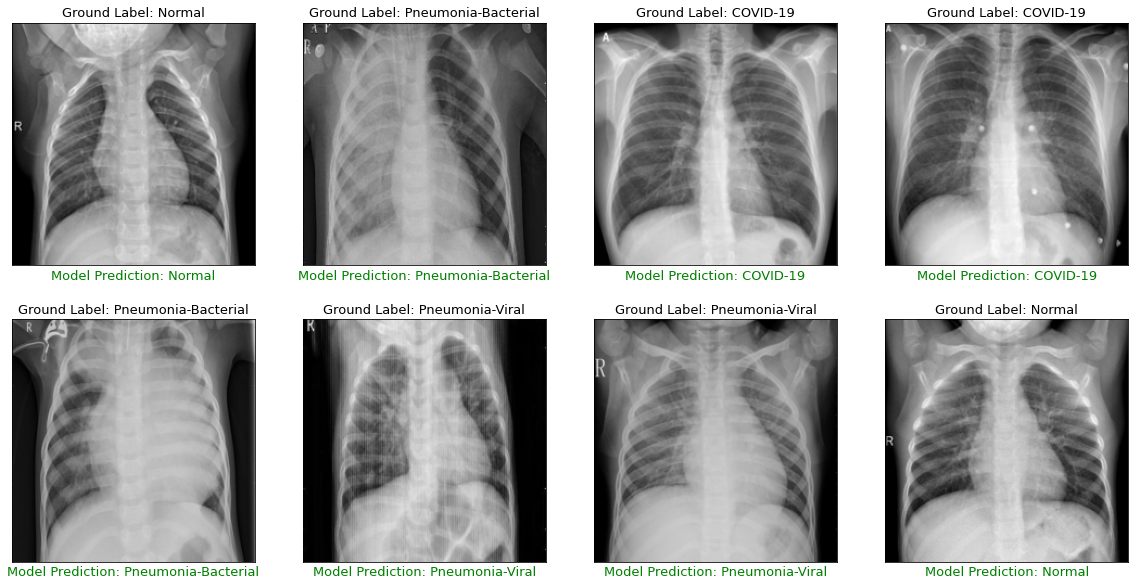

In [ ]:
show_preds()